In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from Temporal_Community_Detection import temporal_network
import random
import pickle
import os

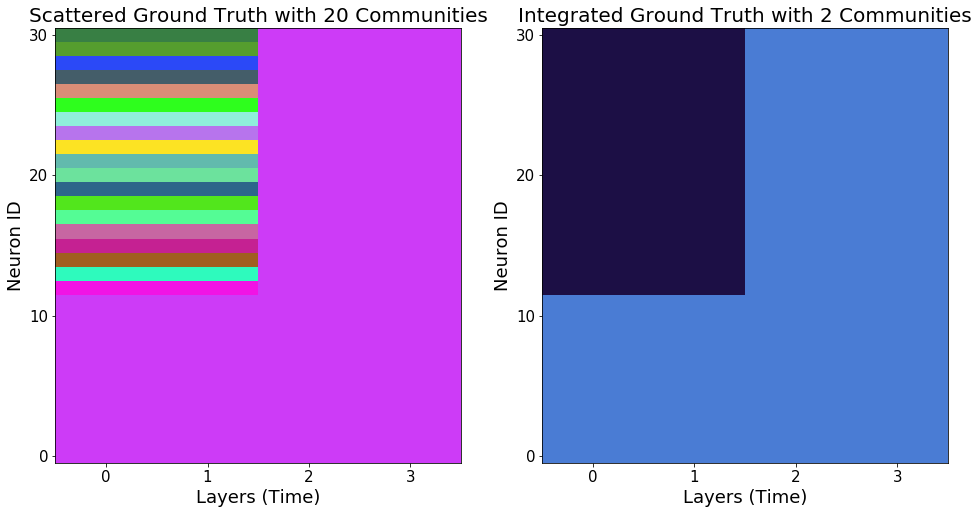

In [3]:
fixed_size = int(abs(np.random.normal(30,10)))
spike_rate = int(abs(np.random.normal(20,8)))# spike rate per commiunity
layers = 2

path = '/projects/academic/smuldoon/bengieru/Community_Detection/effects_of_number_of_layers/layers=%d'%layers

os.makedirs(path, exist_ok = True)

comm_sizes = [int(np.random.power(3/2)*30) for i in range(layers)]
spike_rates = [int(abs(np.random.normal(20,8))) for i in range(layers)]

with open(path + "comm_size.pkl", "wb") as fp:
    pickle.dump(comm_sizes, fp)

window_size = 1000 # size, in frames, each adjacency matrix correspond to. better to be equal to bin_size 
standard_dev = 1.2 # for gaussian kernel
k = 5 #for jittering the spikes
pad = False
num_neurons = sum(comm_sizes)

display_truth(comm_sizes, community_operation = 'grow')
plt.savefig(path + 'Ground_truths.pdf')

In [ ]:
spikes = create_time_series('grow', comm_sizes, spike_rates, windowsize = window_size, k = k)
plt.savefig(path + 'spiketrain.pdf')

In [ ]:
with open(path + "spikes.pkl", "wb") as fp:
    pickle.dump(spikes, fp)

In [ ]:
fig,ax = plt.subplots(1, 1, figsize = (10,10))
n, bins = spike_count(spikes, ax)
plt.savefig(path + 'spike_distribution.pdf')

In [ ]:
binned_spikes = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)
fig,ax = plt.subplots(layers, 1, figsize=(20,50))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'lower', interpolation='nearest', aspect='auto')
    ax[i].set_title('Gaussian Spikes (Layer %d)'%(i+1), fontsize = 20)
    ax[i].set_xlabel('TIME (in Miliseconds)', fontsize = 20)
    ax[i].set_xticks([j*100 for j in range(11)])
    ax[i].set_yticks([j*10 for j in range(int(num_neurons/10)+1)])
    ax[i].set_ylabel('Neuron ID', fontsize = 25)
    ax[i].set_xlabel('Time (Frames)', fontsize = 20)
    ax[i].tick_params(axis = 'both', labelsize = 20)
plt.tight_layout()
plt.savefig(path + 'binned_spiketrain.pdf')

In [ ]:
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])
    
if pad:
    padded_adjacencies = [adjacency_matrices[0]]  + adjacency_matrices + [adjacency_matrices[-1]]
    layers = layers + 2

In [ ]:
fig,ax = plt.subplots(3, 3, figsize = (36,32))
for i in range(3):
    for j in range(3):
        k = ax[i][j].imshow(padded_adjacencies[i*3+j], 
                            origin = 'lower', 
                            interpolation='nearest', 
                            aspect='auto',  
                            extent = [0,num_neurons,0,num_neurons])
        ax[i][j].set_title('Adjacency Matrix (Layer %d)'%(i*3+j +1), fontsize = 35)
        ax[i][j].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i][j].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 20)
fig.suptitle('Community expansion with sizes %d,%d,%d,%d,%d,%d,%d and spike rates %d,%d,%d,%d,%d,%d,%d'%(comm_sizes[0],comm_sizes[1],comm_sizes[2],comm_sizes[3],comm_sizes[4],comm_sizes[5],comm_sizes[6],spike_rates[0],spike_rates[1],spike_rates[2],spike_rates[3],spike_rates[4],spike_rates[5],spike_rates[6]), fontsize = 50)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25) 
plt.savefig(path + 'adjacency.pdf')

In [ ]:
TN = temporal_network(num_neurons, 
                      layers, 
                      window_size, 
                      data = 'list__adjacency', 
                      list_adjacency = padded_adjacencies, 
                      omega = 1, 
                      kind = 'ordinal')

fig,ax = plt.subplots(1,1, figsize = (25,15))
TN.raster_plot(spikes, ax)
plt.savefig(path + 'raster_plot.pdf')

In [ ]:
grid = 51
threshs = np.linspace(0, 0.8, grid)
inters = np.linspace(0, 1.5, grid)

path_no_update = path + 'infomap/no_update/'

os.makedirs(path_no_update, exist_ok = True)

In [ ]:
membership_no_update, labels_no_update = TN.run_community_detection('infomap', 
                                                                    interlayers = inters, 
                                                                    thresholds = threshs)
 
with open(path_no_update + "infomap_labels_no_update.pkl", "wb") as fp:
    pickle.dump(labels_no_update, fp)

In [ ]:
index = 10
for m in range(5):
    for n in range(5):
        fig,ax = plt.subplots(index,index, figsize = (index*15+5,index*15))
        for i in range(index):
            for j in range(index):
                comms, c = TN.community(membership_no_update['interlayer=%.3f'%inters[i+m*index]][j+n*index], ax[i][j])
                ax[i][j].set_xticks([i for i in range(layers)])
                ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
                ax[i][j].tick_params(axis = 'both', labelsize = 12)
                ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
                ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
                ax[i][j].set_title('%d Communities, interlayer:%.3f, threshold:%.3f'%(len(c),inters[i+m*index],threshs[j+n*index]), fontsize=29)
        plt.tight_layout()
        plt.savefig(path_no_update + 'communities_%d.pdf'%((m*5)+n))

In [ ]:
information_recovery(labels_no_update, comm_sizes, 'Scattered', inters, threshs, 'grow')
plt.savefig(path_no_update + 'info_recovery_scattered.pdf')

In [ ]:
information_recovery(labels_no_update, comm_sizes, 'Integrated', inters, threshs, 'grow')
plt.savefig(path_no_update + 'info_recovery_integrated.pdf')

In [ ]:
path_local_update = path + 'infomap/local_update/'

os.makedirs(path_local_update, exist_ok = True)

In [ ]:
membership_local_update, labels_local_update = TN.run_community_detection('infomap', 
                                                                          update_method = 'local', 
                                                                          interlayers = inters, 
                                                                          thresholds = threshs, 
                                                                          spikes = spikes)
with open(path_local_update + "infomap_labels_local_update.pkl", "wb") as fp:
    pickle.dump(labels_local_update, fp)

In [ ]:
index = 10
for m in range(5):
    for n in range(5):
        fig,ax = plt.subplots(index,index, figsize = (index*15+5,index*15))
        for i in range(index):
            for j in range(index):
                comms, c = TN.community(membership_local_update['interlayer=%.3f'%inters[i+m*index]][j+n*index], ax[i][j])
                ax[i][j].set_xticks([i for i in range(layers)])
                ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
                ax[i][j].tick_params(axis = 'both', labelsize = 12)
                ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
                ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
                ax[i][j].set_title('%d Communities, interlayer:%.3f, threshold:%.3f'%(len(c),inters[i+m*index],threshs[j+n*index]), fontsize=29)
        plt.tight_layout()
        plt.savefig(path_local_update + 'communities_%d.pdf'%((m*5)+n))

In [ ]:
information_recovery(labels_local_update, comm_sizes, 'Scattered', inters, threshs, 'grow')
plt.savefig(path_local_update + 'info_recovery_scattered.pdf')

In [ ]:
information_recovery(labels_local_update, comm_sizes, 'Integrated', inters, threshs, 'grow')
plt.savefig(path_local_update + 'info_recovery_integrated.pdf')

In [ ]:
path_global_update = path + 'infomap/global_update/'

os.makedirs(path_global_update, exist_ok = True)

In [ ]:
membership_global_update, labels_global_update = TN.run_community_detection('infomap', 
                                                                            update_method = 'global', 
                                                                            interlayers = inters, 
                                                                            thresholds = threshs, 
                                                                            spikes = spikes)
with open(path_global_update + "infomap_labels_global_update.pkl", "wb") as fp:
    pickle.dump(labels_global_update, fp)

In [ ]:
index = 10
for m in range(5):
    for n in range(5):
        fig,ax = plt.subplots(index,index, figsize = (index*15+5,index*15))
        for i in range(index):
            for j in range(index):
                comms, c = TN.community(membership_global_update['interlayer=%.3f'%inters[i+m*index]][j+n*index], ax[i][j])
                ax[i][j].set_xticks([i for i in range(layers)])
                ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
                ax[i][j].tick_params(axis = 'both', labelsize = 12)
                ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
                ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
                ax[i][j].set_title('%d Communities, interlayer:%.3f, threshold:%.3f'%(len(c),inters[i+m*index],threshs[j+n*index]), fontsize=29)
        plt.tight_layout()
        plt.savefig(path_global_update + 'communities_%d.pdf'%((m*5)+n))

In [ ]:
information_recovery(labels_global_update, comm_sizes, 'Scattered', inters, threshs, 'grow')
plt.savefig(path_global_update + 'info_recovery_scattered.pdf')

In [ ]:
information_recovery(labels_global_update, comm_sizes, 'Integrated', inters, threshs, 'grow')
plt.savefig(path_global_update + 'info_recovery_integrated.pdf')

In [ ]:
path_nbr_update = path + 'infomap/neighborhood_update/'

os.makedirs(path_nbr_update, exist_ok = True)

In [ ]:
membership_nbr_update, labels_nbr_update = TN.run_community_detection('infomap', 
                                                                      update_method = 'neighborhood', 
                                                                      interlayers = inters, 
                                                                      thresholds = threshs)

with open(path_nbr_update + "infomap_labels_nbr_update.pkl", "wb") as fp:
    pickle.dump(labels_nbr_update, fp)

In [ ]:
index = 10
for m in range(5):
    for n in range(5):
        fig,ax = plt.subplots(index,index, figsize = (index*15+5,index*15))
        for i in range(index):
            for j in range(index):
                comms, c = TN.community(membership_nbr_update['interlayer=%.3f'%inters[i+m*index]][j+n*index], ax[i][j])
                ax[i][j].set_xticks([i for i in range(layers)])
                ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
                ax[i][j].tick_params(axis = 'both', labelsize = 12)
                ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
                ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
                ax[i][j].set_title('%d Communities, interlayer:%.3f, threshold:%.3f'%(len(c),inters[i+m*index],threshs[j+n*index]), fontsize=29)
        plt.tight_layout()
        plt.savefig(path_nbr_update + 'communities_%d.pdf'%((m*5)+n))

In [ ]:
information_recovery(labels_nbr_update, comm_sizes, 'Scattered', inters, threshs, 'grow')
plt.savefig(path_nbr_update + 'info_recovery_scattered.pdf')

In [ ]:
information_recovery(labels_nbr_update, comm_sizes, 'Integrated', inters, threshs, 'grow')
plt.savefig(path_nbr_update + 'info_recovery_integrated.pdf')

In [ ]:
print('INFOMAP-->MMM')

In [ ]:
grid = 51

resos = np.linspace(0, 1.5, grid)
inters = np.linspace(0, 0.8, grid)

path_no_update = path + 'MMM/no_update/'

os.makedirs(path_no_update, exist_ok = True)

In [ ]:
membership_no_update, labels_no_update = TN.run_community_detection('MMM', 
                                                                    interlayers = inters, 
                                                                    resolutions = resos)
with open(path_no_update + "MMM_labels_no_update.pkl", "wb") as fp:
    pickle.dump(labels_no_update, fp)

In [ ]:
index = 10
for m in range(5):
    for n in range(5):
        fig,ax = plt.subplots(index,index, figsize = (index*15+5,index*15))
        for i in range(index):
            for j in range(index):
                comms, c = TN.community(membership_no_update['interlayer=%.3f'%inters[i+m*index]][j+n*index], ax[i][j])
                ax[i][j].set_xticks([i for i in range(layers)])
                ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
                ax[i][j].tick_params(axis = 'both', labelsize = 12)
                ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
                ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
                ax[i][j].set_title('%d Communities, interlayer:%.3f, resolution:%.3f'%(len(c),inters[i+m*index],resos[j+n*index]), fontsize=29)
        plt.tight_layout()
        plt.savefig(path_no_update + 'communities_%d.pdf'%((m*5)+n))

In [ ]:
information_recovery(labels_no_update, comm_sizes, 'Scattered', inters, resos, 'grow')
plt.savefig(path_no_update + 'info_recovery_scattered.pdf')

In [ ]:
information_recovery(labels_no_update, comm_sizes, 'Integrated', inters, resos, 'grow')
plt.savefig(path_no_update + 'info_recovery_integrated.pdf')

In [ ]:
path_local_update = path + 'MMM/local_update/'

os.makedirs(path_local_update, exist_ok = True)

In [ ]:
membership_local_update, labels_local_update = TN.run_community_detection('MMM', 
                                                                          update_method = 'local', 
                                                                          interlayers = inters, 
                                                                          resolutions = resos, 
                                                                          spikes = spikes)
with open(path_local_update + "MMM_labels_local_update.pkl", "wb") as fp:
    pickle.dump(labels_local_update, fp)

In [ ]:
index = 10
for m in range(5):
    for n in range(5):
        fig,ax = plt.subplots(index,index, figsize = (index*15+5,index*15))
        for i in range(index):
            for j in range(index):
                comms, c = TN.community(membership_local_update['interlayer=%.3f'%inters[i+m*index]][j+n*index], ax[i][j])
                ax[i][j].set_xticks([i for i in range(layers)])
                ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
                ax[i][j].tick_params(axis = 'both', labelsize = 12)
                ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
                ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
                ax[i][j].set_title('%d Communities, interlayer:%.3f, resolution:%.3f'%(len(c),inters[i+m*index],resos[j+n*index]), fontsize=29)
        plt.tight_layout()
        plt.savefig(path_local_update + 'communities_%d.pdf'%((m*5)+n))

In [ ]:
information_recovery(labels_local_update, comm_sizes, 'Scattered', inters, resos, 'grow')
plt.savefig(path_local_update + 'info_recovery_scattered.pdf')

In [ ]:
information_recovery(labels_local_update, comm_sizes, 'Integrated', inters, resos, 'grow')
plt.savefig(path_local_update + 'info_recovery_integrated.pdf')

In [ ]:
path_global_update = path + 'MMM/global_update/'

os.makedirs(path_global_update, exist_ok = True)

In [ ]:
membership_global_update, labels_global_update = TN.run_community_detection('MMM', 
                                                                            update_method = 'global', 
                                                                            interlayers = inters, 
                                                                            resolutions = resos, 
                                                                            spikes = spikes)
with open(path_global_update + "MMM_labels_global_update.pkl", "wb") as fp:
    pickle.dump(labels_global_update, fp)

In [ ]:
index = 10
for m in range(5):
    for n in range(5):
        fig,ax = plt.subplots(index,index, figsize = (index*15+5,index*15))
        for i in range(index):
            for j in range(index):
                comms, c = TN.community(membership_global_update['interlayer=%.3f'%inters[i+m*index]][j+n*index], ax[i][j])
                ax[i][j].set_xticks([i for i in range(layers)])
                ax[i][j].set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
                ax[i][j].tick_params(axis = 'both', labelsize = 12)
                ax[i][j].set_xlabel('Layers (Time)', fontsize = 25)
                ax[i][j].set_ylabel('Neuron ID', fontsize = 25)
                ax[i][j].set_title('%d Communities, interlayer:%.3f, resolution:%.3f'%(len(c),inters[i+m*index],resos[j+n*index]), fontsize=29)
        plt.tight_layout()
        plt.savefig(path_global_update + 'communities_%d.pdf'%((m*5)+n))

In [ ]:
information_recovery(labels_global_update, comm_sizes, 'Scattered', inters, resos, 'grow')
plt.savefig(path_global_update + 'info_recovery_scattered.pdf')

In [ ]:
information_recovery(labels_global_update, comm_sizes, 'Integrated', inters, resos, 'grow')
plt.savefig(path_global_update + 'info_recovery_integrated.pdf')